**Data Source**: /projectnb/ds598/projects/smart_brains/dataset

In [1]:
from IPython.display import Markdown, display
folder_path = "/projectnb/ds598/projects/smart_brains/dataset/MICCAI_FeTS2021_TrainingData"
display(Markdown(f'{folder_path}/README.md'))

# Description for FeTS Challenge 2021 data



## Data Partitioning Information

We provide two strategies to partition the data:

1. **Natural partitioning by institution** 
  File: `partitioning_1.csv`
  Description: Each institution ID represents the originating institution.

2. **Artificial partitioning using imaging information** 
  File: `partitioning_2.csv`
  Description: This is same as the institution split, but after further partitioning each of the 5 largest institutions according to the information extracted from the images. Specifically, after measuring the whole tumor size for all records, the median size was used as threshold to create extra partitions.

We encourage participants to create and explore further partitioning strategies using any information they would feel is relevant, to contribute towards the generalizability of their proposed method.



## Data Use Agreement

You are free to use and/or refer to the FeTS challenge and datasets in your own research, provided that you always cite the following three manuscripts:

1. S.Pati, U.Baid, M.Zenk, B.Edwards, M.Sheller, G.A.Reina, et al., "The Federated Tumor Segmentation (FeTS) Challenge", arXiv preprint arXiv:2105.05874 (2021)

2. G.A.Reina, A.Gruzdev, P.Foley, O.Perepelkina, M.Sharma, I.Davidyuk, et al., “OpenFL: An open-source framework for Federated Learning”, arXiv preprint arXiv: 2105.06413 (2021)

3. S.Bakas, H.Akbari, A.Sotiras, M.Bilello, M.Rozycki, J.S.Kirby, et al., "Advancing The Cancer Genome Atlas glioma MRI collections with expert segmentation labels and radiomic features", Nature Scientific Data, 4:170117 (2017) DOI: 10.1038/sdata.2017.117

Additionally, the manuscript below contains results of a simulated study directly related to the FeTS challenge.

4. M.J.Sheller, B.Edwards, G.A.Reina, J.Martin, S.Pati, A.Kotrotsou, et al., "Federated learning in medicine: facilitating multi-institutional collaborations without sharing patient data", Nature Scientific Reports, 10:12598 (2020)   DOI: 10.1038/s41598-020-69250-1

Finally, the following is a data citations directly referring to the TCGA-GBM and TCGA-LGG collections used as part of the FeTS dataset.

5. S.Bakas, H.Akbari, A.Sotiras, M.Bilello, M.Rozycki, J.Kirby, et al., "Segmentation Labels and Radiomic Features for the Pre-operative Scans of the TCGA-GBM collection", The Cancer Imaging Archive, 2017. DOI: 10.7937/K9/TCIA.2017.KLXWJJ1Q 

6. S.Bakas, H.Akbari, A.Sotiras, M.Bilello, M.Rozycki, J.Kirby, et al., "Segmentation Labels and Radiomic Features for the Pre-operative Scans of the TCGA-LGG collection", The Cancer Imaging Archive, 2017. DOI: 10.7937/K9/TCIA.2017.GJQ7R0EF



## More information

- https://miccai2021.fets.ai/
- https://github.com/FETS-AI/Challenge/
- Follow us on https://twitter.com/FeTS_Challenge



## Contact the organizers

- https://github.com/FETS-AI/Challenge/discussions
- challenge@fets.ai

# 0 Check Directory & Import Packages

In [2]:
# Check folder names
!ls /projectnb/ds598/projects/smart_brains/dataset

MICCAI_FeTS2021_TrainingData	MICCAI_FeTS2021_ValidationData_nolabel
MICCAI_FeTS2021_ValidationData


In [3]:
# Check number of training data
!ls /projectnb/ds598/projects/smart_brains/dataset/MICCAI_FeTS2021_TrainingData | wc -l
# Check number of validation data
!ls /projectnb/ds598/projects/smart_brains/dataset/MICCAI_FeTS2021_ValidationData | wc -l

344
4


In [4]:
# Check the content in each folder
!ls /projectnb/ds598/projects/smart_brains/dataset/MICCAI_FeTS2021_TrainingData/FeTS21_Training_001

FeTS21_Training_001_flair.nii  FeTS21_Training_001_t1ce.nii
FeTS21_Training_001_seg.nii    FeTS21_Training_001_t2.nii
FeTS21_Training_001_t1.nii     Training_001_t1ce_slide_windows


In [5]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting
import pandas as pd
import torch
from torch.utils.data import Dataset

# 1 Load Data

## 1.1 Visualize Data

In [6]:
def load_nii(nii_file_path):
    nii_image = nib.load(nii_file_path)
    image_data = nii_image.get_fdata()
    return image_data
def plot_nii_slice(nii_file_path, slice = 78, gray=False):
    nii_image = nib.load(nii_file_path)
    image_data = nii_image.get_fdata()
    if gray:
        plt.imshow(image_data[:, :, slice], cmap='gray')
    else:
        plt.imshow(image_data[:, :, slice])
    plt.show()
def plot_nii(nii_file_path):
    plotting.plot_img(nii_file_path)
    plotting.show()

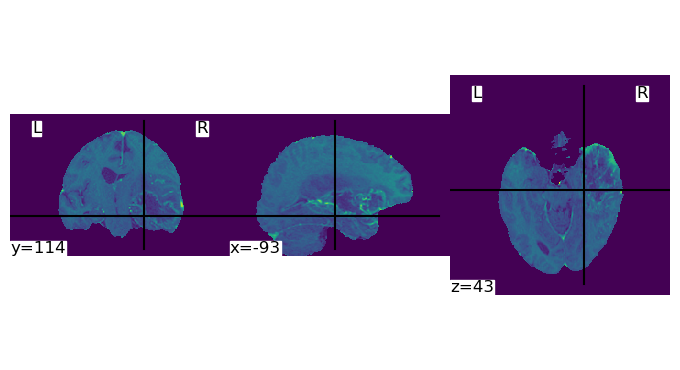

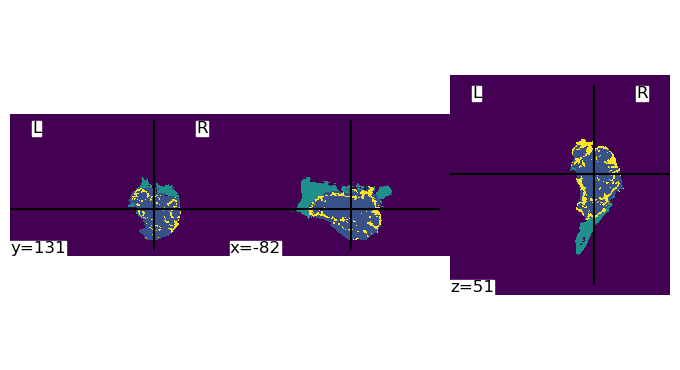

In [7]:
id = "020"
modal_types = ["flair", "t1", "t1ce", "t2"]
modal_type = "t1ce"
training_path = "/projectnb/ds598/projects/smart_brains/dataset/MICCAI_FeTS2021_TrainingData"
image_path = f"{training_path}/FeTS21_Training_{id}/FeTS21_Training_{id}_{modal_type}.nii"
label_path = f"{training_path}/FeTS21_Training_{id}/FeTS21_Training_{id}_seg.nii"
plot_nii(image_path)
plot_nii(label_path)

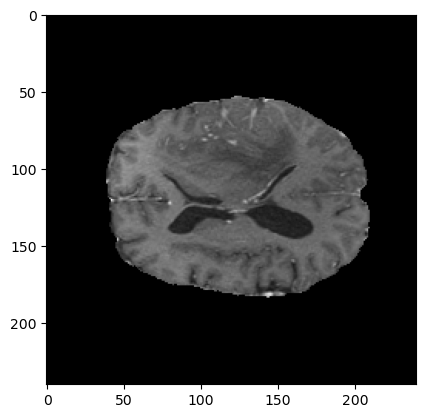

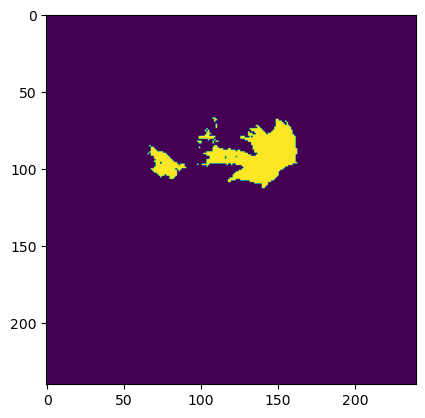

In [8]:
plot_nii_slice(image_path, slice = 78, gray=True)
plot_nii_slice(label_path, slice = 78)

## 1.2 Load all data

In [9]:
training_folder_path = "/projectnb/ds598/projects/smart_brains/dataset/MICCAI_FeTS2021_TrainingData"
training_folder_names = sorted([fname for fname in os.listdir(training_folder_path) if "FeTS21" in fname])
print(f"There are {len(training_folder_names)} Training Data, from {training_folder_names[0].split('_')[-1]} to {training_folder_names[-1].split('_')[-1]}")

There are 341 Training Data, from 001 to 369


In [10]:
training_folder_path = "/projectnb/ds598/projects/smart_brains/dataset/MICCAI_FeTS2021_TrainingData"
otherfile_names = [fname for fname in os.listdir(training_folder_path) if "FeTS21" not in fname]
otherfile_names

['partitioning_1.csv', 'README.md', 'partitioning_2.csv']

In [11]:
partitioning_1 = pd.read_csv(f"{folder_path}/partitioning_1.csv").sort_values(by="Subject_ID")
partitioning_2 = pd.read_csv(f"{folder_path}/partitioning_2.csv").sort_values(by="Subject_ID")

In [12]:
validation_folder_path = "/projectnb/ds598/projects/smart_brains/dataset/MICCAI_FeTS2021_ValidationData"
validation_folder_names = sorted([fname for fname in os.listdir(validation_folder_path) if "FeTS21" in fname])
print(f"There are {len(validation_folder_names)} Validation Data, from {validation_folder_names[0].split('_')[-1]} to {validation_folder_names[-1].split('_')[-1]}")

There are 111 Validation Data, from 001 to 125


In [13]:
folder_path = "/projectnb/ds598/projects/smart_brains/dataset/MICCAI_FeTS2021_ValidationData"
otherfile_names = [fname for fname in os.listdir(folder_path) if "FeTS21" not in fname]
otherfile_names

[]

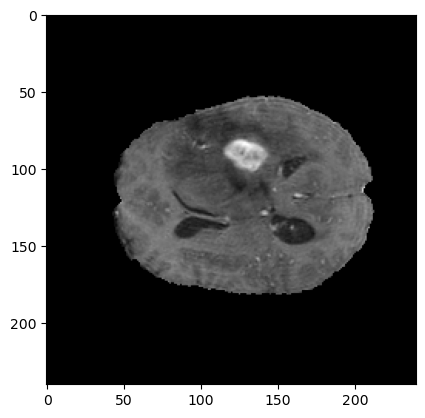

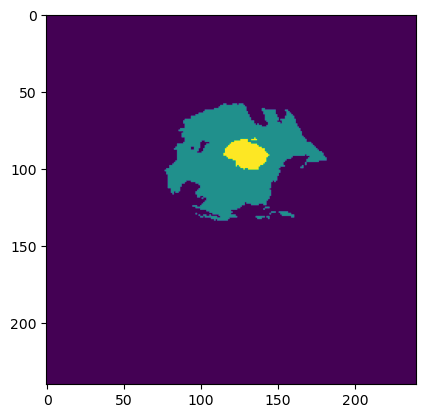

In [14]:
modal_type = "t1ce"
image_path = f"{training_folder_path}/FeTS21_Training_{id}/FeTS21_Training_{id}_{modal_type}.nii"
label_path = f"{training_folder_path}/FeTS21_Training_{id}/FeTS21_Training_{id}_seg.nii"
plot_nii_slice(image_path, gray = True)
plot_nii_slice(label_path)

In [15]:
image_array = load_nii(image_path)
label_array = load_nii(label_path)
label_class = [int(each) for each in list(np.unique(label_array))]
label_class.remove(0)
print(f"Number of class = {len(label_class)}, They are {label_class}")

Number of class = 3, They are [1, 2, 4]


In [16]:
# find all image path and label_path
modal_type = "t1ce"
training_image_paths = [f"{training_folder_path}/{training_folder_name}/{training_folder_name}_{modal_type}.nii" for training_folder_name in training_folder_names]
training_label_paths = [f"{training_folder_path}/{training_folder_name}/{training_folder_name}_seg.nii" for training_folder_name in training_folder_names]
validation_image_paths = [f"{validation_folder_path}/{validation_folder_name}/{validation_folder_name}_{modal_type}.nii" for validation_folder_name in validation_folder_names]
validation_label_paths = [f"{validation_folder_path}/{validation_folder_name}/{validation_folder_name}_seg.nii" for validation_folder_name in validation_folder_names]


In [17]:
def load_nii_slice(nii_file_path, slice = 78):
    nii_image = nib.load(nii_file_path)
    image_data = nii_image.get_fdata()
    return image_data[:, :, slice]

class BRATS21_Dataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.images, self.labels = image_paths, label_paths
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img = load_nii_slice(self.images[index], slice = 78)
        label = load_nii_slice(self.labels[index], slice = 78)
        # split channels
        return img,label

In [18]:
training_Dataset = BRATS21_Dataset(training_image_paths, training_label_paths)
validation_Dataset = BRATS21_Dataset(validation_image_paths, validation_label_paths)

In [19]:
batch_size = 8
shuffle = True
pin_memory = True # Setting to True, it enables fast data transfer to CUDA-enabled GPUs
training_dataloader = torch.utils.data.DataLoader(training_Dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
validation_dataloader = torch.utils.data.DataLoader(validation_Dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)


In [20]:
training_Dataset[0][0].shape, training_Dataset[0][1].shape

((240, 240), (240, 240))

## 1.3 Combine Data loading into a function

In [21]:
def load_nii_slice(nii_file_path, slice = 78):
    nii_image = nib.load(nii_file_path)
    image_data = nii_image.get_fdata()
    return image_data[:, :, slice]

def one_hot_encoder(matrix, values_map = {0: 0, 1: 1, 2: 2, 4: 3}):
    one_hot_encoded_matrix = np.zeros((matrix.shape[0], matrix.shape[1], 4))
    # Populate the one hot encoded matrix
    for key, value in values_map.items():
        one_hot_encoded_matrix[:, :, value] = (matrix == key).astype(int)
    return one_hot_encoded_matrix

In [22]:
# 0: [1,0,0,0]
# 1: [0,1,0,0]
# 2: [0,0,1,0]
# 4: [0,0,0,1]

In [23]:
class BRATS21_Dataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.images, self.labels = image_paths, label_paths
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img = load_nii_slice(self.images[index], slice = 78)
        label = load_nii_slice(self.labels[index], slice = 78) # (240, 240)
        one_hot_encoded_label = one_hot_encoder(label) # (240, 240, 4)
        return img, one_hot_encoded_label # -> (240, 240) ; (240, 240, 4)

In [24]:
# get image/label file path saved
training_folder_path = "/projectnb/ds598/projects/smart_brains/dataset/MICCAI_FeTS2021_TrainingData"
training_folder_names = sorted([fname for fname in os.listdir(training_folder_path) if "FeTS21" in fname])
print(f"There are {len(training_folder_names)} Training Data, from {training_folder_names[0].split('_')[-1]} to {training_folder_names[-1].split('_')[-1]}")

validation_folder_path = "/projectnb/ds598/projects/smart_brains/dataset/MICCAI_FeTS2021_ValidationData"
validation_folder_names = sorted([fname for fname in os.listdir(validation_folder_path) if "FeTS21" in fname])
print(f"There are {len(validation_folder_names)} Validation Data, from {validation_folder_names[0].split('_')[-1]} to {validation_folder_names[-1].split('_')[-1]}")

modal_type = "t1ce"
training_image_paths = [f"{training_folder_path}/{training_folder_name}/{training_folder_name}_{modal_type}.nii" for training_folder_name in training_folder_names]
training_label_paths = [f"{training_folder_path}/{training_folder_name}/{training_folder_name}_seg.nii" for training_folder_name in training_folder_names]
validation_image_paths = [f"{validation_folder_path}/{validation_folder_name}/{validation_folder_name}_{modal_type}.nii" for validation_folder_name in validation_folder_names]
validation_label_paths = [f"{validation_folder_path}/{validation_folder_name}/{validation_folder_name}_seg.nii" for validation_folder_name in validation_folder_names]

# create dataset object
training_Dataset = BRATS21_Dataset(training_image_paths, training_label_paths)
validation_Dataset = BRATS21_Dataset(validation_image_paths, validation_label_paths)

# create data loader
batch_size = 8
shuffle = True
pin_memory = True # Setting to True, it enables fast data transfer to CUDA-enabled GPUs
training_dataloader = torch.utils.data.DataLoader(training_Dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
validation_dataloader = torch.utils.data.DataLoader(validation_Dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)



There are 341 Training Data, from 001 to 369
There are 111 Validation Data, from 001 to 125


In [25]:
def one_hot_encoder(matrix, values_map = {0: 0, 1: 1, 2: 2, 4: 3}):
    one_hot_encoded_matrix = np.zeros((matrix.shape[0], matrix.shape[1], 4))
    # Populate the one hot encoded matrix
    for key, value in values_map.items():
        one_hot_encoded_matrix[:, :, value] = (matrix == key).astype(int)
    return one_hot_encoded_matrix

matrix = training_Dataset[0][0]
one_hot_encoded_matrix = one_hot_encoder(matrix)
one_hot_encoded_matrix.shape

(240, 240, 4)